<img style="float: right; margin: 0px 0px 15px 15px;" src="https://educationusa.state.gov/sites/default/files/wysiwyg/iteso_logo.jpg" width="300px" height="300px" />

`Trading Microstructure`

**Ulises Rodrigo León Ortiz**  
**Bryan Edwin Castelan**  
**Paulina Raquel Monroy Salcido** 


## 001 Microstructure Project

## Information-based Models

### Parameters
 - **Stock Price ($P$)**  
 $P \sim \mathcal{Erlang}(K=60, \lambda = 3)\$  
 
    $P:[10,33] $


 
 - **Probability of an Informed Trade ($\Pi_{I}$)**  
 
 $\Pi_{I} = 0.4$
 
 
 - **Probability of a Liquidity Buy ($\Pi_{LB}(S)$)**  
   
  $\Pi_{LB}(S) = 0.5 - 0.08S$ where $\Pi_{LB}: [0, 0.5]$
  
  
- **Probability of a Liquidity Sell ($\Pi_{LS}(S)$):**  
  
  $\Pi_{LS}(S) = 0.5 - 0.08S$ where $\Pi_{LS}: [0, 0.5]$  
  
  
- **Initial Stock Price ($P_0$):**  

  $P_0 = 19.90$  
  
 
- **Bid-Ask Spread which Maximizes the Expected Profit**  
$
\begin{aligned}
& \max _{K_A, K_B}\left\{\left(1-p_I\right)\left[p_{B L}\left(K_A-S_0\right)+p_{S L}\left(S_0-K_B\right)\right]\right.\left.-p_I\left[\int_{K_A}^{\infty}\left(S-K_A\right) f(S) d S+\int_0^{K_B}\left(K_B-S\right) f(S) d S\right]\right\} \geq 0
\end{aligned}
$



### 1. Plot the price distribution

In [1]:
#  Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import erlang
from scipy import integrate, optimize

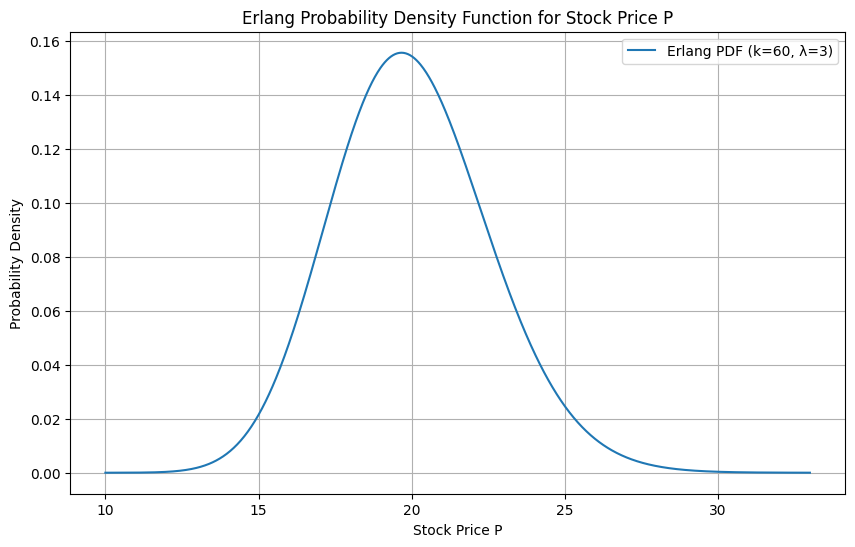

In [2]:
# Parameters
k = 60  # Shape 
lambda_ = 3  # Rate

# Scale for the Erlang distribution
scale = 1/lambda_
erlang_dist = erlang(k, scale=scale)

# Values for x for plotting
x_values = np.linspace(10, 33, 1000)  # Adjusting the x range from 10 to 33
pdf_values = erlang_dist.pdf(x_values)

# Plotting the probability density function
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label=f'Erlang PDF (k={k}, λ={lambda_})')
plt.title('Erlang Probability Density Function for Stock Price P')
plt.xlabel('Stock Price P')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

### 2. Create a plot showing:
- Expected revenue if all trades are liquidity trades, and $\Pi_{LB}=\Pi_{LS} =0.5$
- Expected revenue if there is a 40% chance that an informed trade will be executed, keep the same liquidity probabilities as the previous point.
- Expected revenue considering:
    - $\Pi_{i}=0.4$
    - $\Pi_{LB}(S)= 0.5 - 0.08S$ where $\Pi_{LB}:[0,0.5]$
    - $\Pi_{LS}(S)= 0.5 - 0.08S$ where $\Pi_{LS}:[0,0.5]$

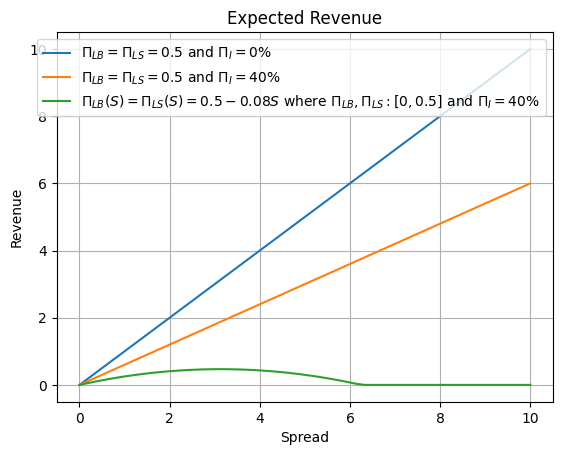

In [3]:
# Define the probability function f(x)
def operation_probability(spread):
    # Calculate probability as a function of spread
    probability = 0.5 - 0.08 * spread
    return np.maximum(probability, 0)

# Generate spread values
spread_values = np.linspace(0, 10)


# Calculate revenue values by applying the operation_probability function to each spread value
revenue_values = [operation_probability(spread) for spread in spread_values]

# Plotting three scenarios with different assumptions for probabilities and revenue calculations
# First plot: Constant probabilities for liquidity buyers (LB) and sellers (LS)
plt.plot(spread_values, spread_values, label='$ \Pi_{LB} = \Pi_{LS} = 0.5 $ and $ \Pi_{I} = 0 \% $')
# Second plot: Same constant probabilities buT there is a 40% chance that an informed trade will be executed
plt.plot(spread_values, spread_values * 0.6, label='$ \Pi_{LB} = \Pi_{LS} = 0.5 $ and $ \Pi_{I} = 40 \% $')
# Third plot: Probabilities for LB and LS adjust with spread (decreasing as spread increases), and 40% chance that an informed trade will be executed
plt.plot(spread_values, spread_values * 0.6 * revenue_values, label='$ \Pi_{LB}(S) = \Pi_{LS}(S) = 0.5 - 0.08 S $ where $ \Pi_{LB} , \Pi_{LS}: [0,0.5] $ and $ \Pi_{I} = 40 \% $')

# Plot the Expected Revenue
plt.xlabel('Spread')
plt.ylabel('Revenue')
plt.title('Expected Revenue')
plt.grid()
plt.legend()
plt.show()



### 3. Determine the optimal Bid / Ask price using Copeland & Galai's model.

In [4]:
def Ask_Bid(P, Ask, Bid, lambda_, k, Prob_Inf, Prob_Liq, So):
    # Calculate potential profit and loss based on Ask and Bid prices relative to the starting price (So)
    S_lb = Ask - So  # Profit
    S_ls = So - Bid  # Loss
    # Adjust probabilities based on the potential profit and loss
    P_lb = 0.5 - 0.08 * S_lb
    P_ls = 0.5 - 0.08 * S_ls

    
    # The function thats inside the integral 
    # Curve Ask 
    def f1(P):
        return (P - Ask) * erlang.pdf(P, k, scale=1/lambda_)

    # Curve Bid
    def f2(P):
        return (Bid - P) * erlang.pdf(P, k, scale=1/lambda_)

    # Integral to obtain possible loss outcomes
    Int1, _ = integrate.quad(f1, Ask, 33)
    Int2, _ = integrate.quad(f2, 10, Bid)

    # Loss
    L = Int1 + Int2
    
    # Utilidad 
    U = (Ask - So) * P_lb * Prob_Liq + (So - Bid) * P_ls * Prob_Liq - Prob_Inf * L

    return -U  # Negative to comply with the minimize convention

# Optimization Function
def Optimize_Ask_Bid(Prob_Inf, Prob_Liq, So, lambda_, k):
    bounds = [(19.90, 33), (10, 19.90)]  # Restrictions for ask and bid > 0
    # Minimization using scipy.optimize's minimize function
    result = optimize.minimize(
        lambda x: Ask_Bid(P, x[0], x[1], lambda_, k, Prob_Inf, Prob_Liq, So),
        x0=[19.90, 19.90],  # Initial values for ask and bid
        bounds=bounds,
    )
    # Return the optimized ask and bid prices
    return result.x[0], result.x[1]

# Parameters
Prob_Inf = 0.4
Prob_Liq = 1-Prob_Inf
So = 19.90
lambda_ = 3
k = 60  
scale_lambda = 1 / lambda_
size = 1000  # Número de valores a generar
P = erlang.rvs(a=k, scale=scale_lambda, size=size)

# Optimum values for Ask & Bid
Ask_opt, Bid_opt = Optimize_Ask_Bid(Prob_Inf, Prob_Liq, So, lambda_, k)

print("The optimal Ask is:", Ask_opt)
print("The optimal Bid is:", Bid_opt)


The optimal Ask is: 23.427630722918607
The optimal Bid is: 16.45168244826142


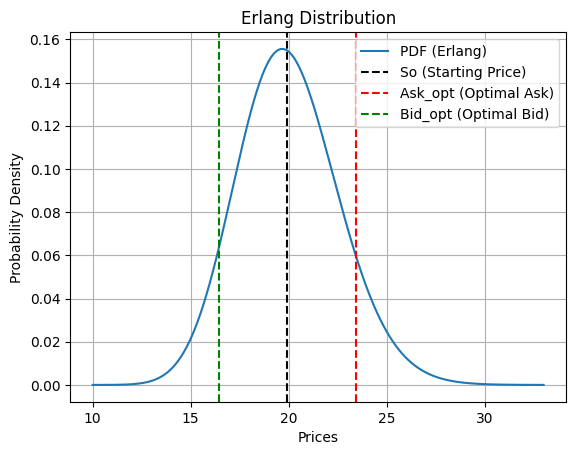

In [7]:
# Plot the optimal Bid - Ask price 
# Plot the probability density function (PDF) for the Erlang distribution
plt.plot(x_values, pdf_values, label='PDF (Erlang)')

# Starting price 'So'
plt.axvline(x=So, color='black', linestyle='--', label='So (Starting Price)')
# Optimal ask price 'Ask_opt'
plt.axvline(x=Ask_opt, color='r', linestyle='--', label='Ask_opt (Optimal Ask)')
# Optimal bid price 'Bid_opt'
plt.axvline(x=Bid_opt, color='g', linestyle='--', label='Bid_opt (Optimal Bid)')

# Plot 
plt.title('Erlang Distribution')
plt.xlabel('Prices')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()
